In [ ]:
pip install --upgrade jupyterlab ipympl

In [ ]:
# In this file, we train and test all of the data, and we visualise it in several graphs

# run preprocessing and classification to use functions
%run Preprocessing.ipynb
%run Classification.ipynb

# create list of worded columns and list of columns to drop
classes = ["Compound", "A", "B", "In literature", "Lowest distortion"]
drop_list = ["Compound", "In literature", "A", "B", "τ"]

file_directory = "Crystal_structure.csv"

# get preprocessed data
pp = Preprocessor(replaceNAN = True, useScaler = True, scaletype = "standard")
clean = pp.Process(file_directory, drop_list, classes)

# split data using conventional data
split_data = SplitData(clean)

# split data using stratified k folds and run classification k times
k_folds = KFoldSplit(clean, 10)

# make tuple of classifiers to use (if defined above) 
classifiers = (RandomForest, KNN, Logistic)

print(f"VISUAL DATA FOR SINGLE FOLD \n")

# we first run only one fold of data using conventional train/test split. This split will be visualised in a graph
for classifier in classifiers:
    classifier(split_data)
print(f"STRATIFIED CROSS VALIDATION USING {len(k_folds)} FOLDS ... \n")   

# run cross validation and store dictionary of classifiers with their f1 scores after k folds have been averaged
score_dictionary = CrossValidate(k_folds, classifiers)

print(score_dictionary)


In [3]:
# we have now found that random forest yields the best results, so we will use it from here on out. We will now study the
# effect on the scores when one of the dependant variables are removed

# read the csv file and grab columns we need
data = pd.read_csv(file_directory)

# remove dependant column
independant_columns = list(data.columns)
independant_columns.remove("Lowest distortion")

# create list of columns excluding the dependant column that are not dropped
used_columns = [i for i in independant_columns if i not in drop_list]

# create dictionary with key as column removed and f1 scores as value
scores_dict = {}

# iterate through these columns and run 5 fold cross validation for random forest algorithm with column removed

for removed_column in used_columns:
    print(f"removing {removed_column}...")
    
    # add column to drop_list
    drop_list.append(removed_column)
    
    # get preprocessed data:
    clean = pp.Process(file_directory, drop_list, classes)
    
    # get 5 fold split
    k_split = KFoldSplit(clean, 3)
    
    # have one tuple which includes only random forest
    classifiers = (RandomForest, )
    
    # run classification.ipynb's cross-validation function and return dict with one key-value pair
    report = CrossValidate(k_split, classifiers)
    
    # add random forest score to dictionary with the removed column
    scores_dict[f"{removed_column}"] = report["RandomForest"]
    
    # at the end, remove column from drop list and continue
    drop_list.remove(removed_column)
    continue

print(scores_dict)
# for score dictionary, each key is a classifier with its values being a tuple where:
# 0: average score, 1: macro average score, 2: weighted average score

removing v(A)...
removing v(B)...
removing r(AXII)(Å)...
removing r(AVI)(Å)...
removing r(BVI)(Å)...
removing EN(A)...
removing EN(B)...
removing l(A-O)(Å)...
removing l(B-O)(Å)...
removing ΔENR...
removing tG...
removing μ...
{'v(A)': (0.7778649830127652, 0.5606259391195988, 0.7667945099292915), 'v(B)': (0.7759660863260683, 0.5636159725765528, 0.7652422984362836), 'r(AXII)(Å)': (0.7789978965105617, 0.5528489819902409, 0.7665469309299952), 'r(AVI)(Å)': (0.7670571391551938, 0.5477242652452436, 0.7550312627454235), 'r(BVI)(Å)': (0.7805143405721223, 0.5595005249002779, 0.7684756028371673), 'EN(A)': (0.774449965646096, 0.5531894637558553, 0.762524545676531), 'EN(B)': (0.7640250055891119, 0.538883361565852, 0.7532799703346559), 'l(A-O)(Å)': (0.7788068857857192, 0.5432656453491921, 0.7662241213938191), 'l(B-O)(Å)': (0.7727446667369483, 0.5496035749407481, 0.7616575356384595), 'ΔENR': (0.7761549411736551, 0.5535647666836478, 0.7648383020142568), 'tG': (0.7881000102835345, 0.5647844135132617, 

<IPython.core.display.Javascript object>


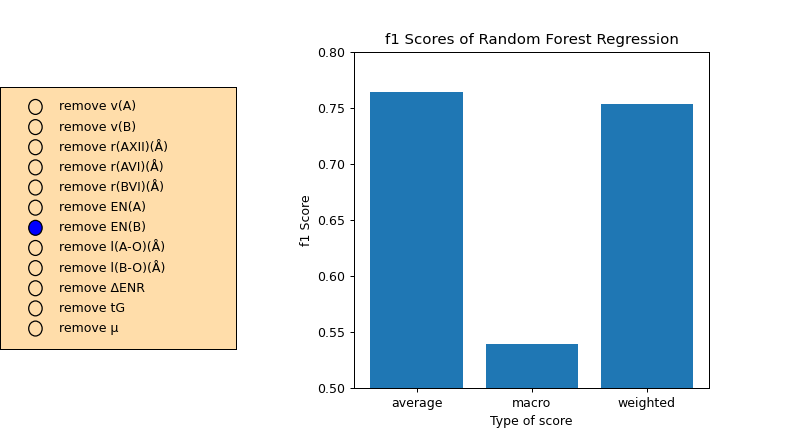

0

In [4]:
%matplotlib nbagg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.widgets
import seaborn as sns


# now we will visualise the effect of removing variables on the scores by using an interactive bar chart

def callback(label: str) -> None:
    """Callback Function called by event handler
        Input:
        label: string of category passed by handler
        
        Returns: None"""
    
    # find index of text in category list
    index = categories.index(label)
    
    # use index to get name of column removed and find its score
    removed_column = used_columns[index]
    y = scores_dict[removed_column]
    
    # clear axes and plot bar chart
    ax.clear()
    ax.bar(x, y)
    
    # reset properties of bar chart
    ax.set_ylim(0.5, 0.8)
    ax.set_title("f1 Scores of Random Forest Regression")
    ax.set_ylabel("f1 Score")
    ax.set_xlabel("Type of score")


# create categories
categories = [f"remove {removed_column}" for removed_column in used_columns]
x = ["average", "macro", "weighted"]

# get axes ready to plot
fig, ax = plt.subplots(figsize = (9, 9))
plt.subplots_adjust(left=0.45)

ax.set_title("f1 Scores of Random Forest Regression")
ax.set_ylabel("f1 Score")
ax.set_xlabel("Type of score")
ax.set_ylim(0.5, 0.8)

#plot bar chart
ax.bar(x ,scores_dict["v(A)"])

# create radio box and remove tick labels
box = plt.axes([0.0, 0.2, 0.3, 0.6], facecolor='#FFDDAA')
box.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

# add buttons
buttons = matplotlib.widgets.RadioButtons(box, categories)

buttons.on_clicked(callback)

In [ ]:
# It was thus found that setting removing EN(B) affected the score of the data the most